# Regression Uncertainty Analysis in Bayesian Deep Learning with Tensorflow Probability

Here is [astroNN](https://github.com/henrysky/astroNN), please take a look if you are interested in astronomy or how neural network applied in astronomy
* **Henry Leung** - *Astronomy student, University of Toronto* - [henrysky](https://github.com/henrysky)
* Project adviser: **Jo Bovy** - *Professor, Department of Astronomy and Astrophysics, University of Toronto* - [jobovy](https://github.com/jobovy)
* Contact Henry: henrysky.leung [at] mail.utoronto.ca
* This tutorial is created on 17/July/2018 with Tensorflow 1.9.0, Tensorflow Probability 0.2.0rc0, Nvidia CuDNN 6.1 for CUDA 8.0 (Optional)

<br>

For more resources on Bayesian Deep Learning with Reparameterization Tricks/Flipout, please refer to [README.md](https://github.com/henrysky/astroNN/tree/master/demo_tutorial/NN_uncertainty_analysis)

Import everything we need

In [2]:
%matplotlib inline
import numpy as np
import pylab as plt
import random

from keras.layers import Dense
from keras.models import Model, Sequential, Input
from keras.layers import Dense, InputLayer, Activation, regularizers
from keras import initializers
from keras.optimizers import Adam
from keras.backend import learning_phase, function
import keras.backend as K

# To get plot_model works, you need to install graphviz and pydot_ng
from keras.utils import plot_model

Using TensorFlow backend.


The equation we use neural net to do regression is
$y=x \sin(x)$

In [3]:
def gen_function(x):
    return(x*np.sin(x))

#### Here, we will generate data with the regression task

Genereate data with three different region to simulate different situation

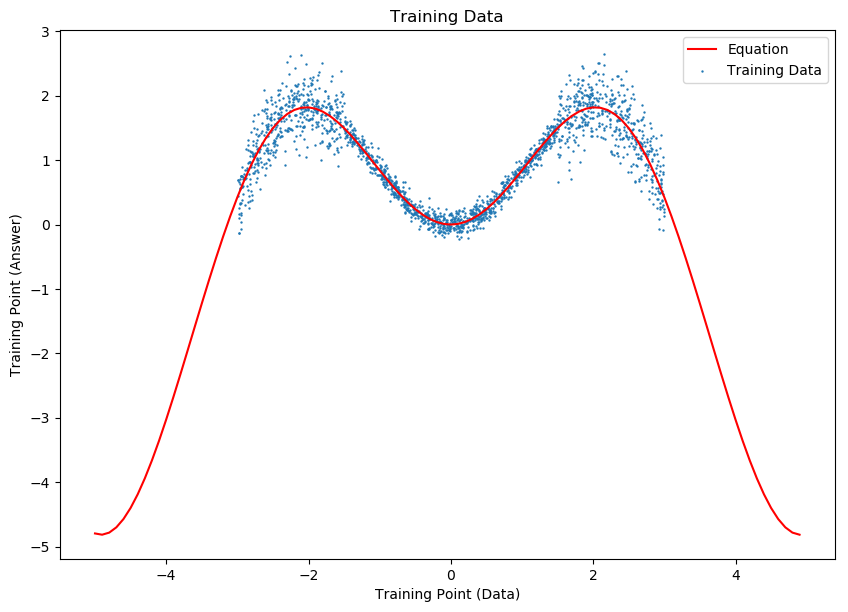

In [11]:
# Four different region, 
x_1 = np.random.uniform(-1.5, 1.5, 1000)
x_2 = np.random.uniform(-3, -1.5, 500)
x_3 = np.random.uniform(1.5, 3, 500)
                        
# Corresponding answer and add different noise and bias
y_1 = gen_function(x_1) + np.random.normal(0.0, 0.1, size=x_1.shape)
y_2 = gen_function(x_2) + np.random.normal(0.0, 0.3, size=x_2.shape)
y_3 = gen_function(x_3) + np.random.normal(0.0, 0.3, size=x_3.shape)


# Error of four different region
y_1_err = np.ones(y_1.shape) * 0.1
y_2_err = np.ones(y_2.shape) * 0.3
y_3_err = np.ones(y_3.shape) * 0.3

y_err = np.hstack((y_1_err,y_2_err,y_3_err)).ravel()

# Combine those 4 regions
x = np.hstack((x_1,x_2,x_3)).ravel()
y = np.hstack((y_1,y_2,y_3)).ravel()

# Mean and Standard Derivation for normalization and denormalization
x_mean = np.mean(x)
x_std = np.std(x)
y_mean = np.mean(y)
y_std = np.std(y)

# Array to plot the real equation lines
x_true = np.arange(-5.0,5,0.1)
y_true = gen_function(x_true)

# Matlibplot
plt.figure(figsize=(10, 7), dpi=100)
plt.title('Training Data')
plt.scatter(x, y, s=0.5, label='Training Data')
plt.plot(x_true, y_true, color='red', label='Equation')
plt.xlabel('Training Point (Data)')
plt.ylabel('Training Point (Answer)')
plt.legend(loc='best')
plt.show()

In [5]:
def normalize(data, mean, std):
    return (data-mean) / std

def denormalize(data, mean, std):
    return (data * std) + mean

# First, we will just use a very simple neural network (2 layers, 75 and 50 neurones respectively) to do the regression task without any fancy methods.

Please notice this is just for the sake of demonstartion. In real world application, please add reguarization (Validation, Early Stop, Reduce Learning Rate) and don not train 100 epochs for such simple task.
<br>

Another thing you should keep in mind neural net is a function approximation method, it will only work well with its training data domain, you can see testing data >1.0, the neural network performs poorly as it has never been trained on.

#### Remember!!! Great Power comes with Great Overfitting (2016, someone on Reddit)

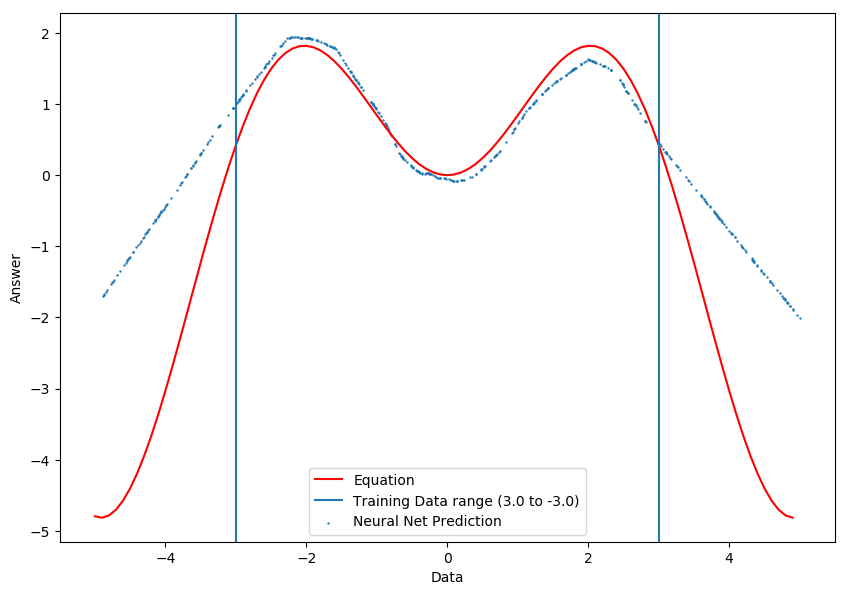

In [6]:
def model_regression(num_hidden):
    # Defeine Keras model for regression
    model = Sequential()
    model.add(InputLayer(batch_input_shape=((None, 1))))
    model.add(Dense(units=num_hidden[0], kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(units=num_hidden[1], kernel_initializer='he_normal', activation='relu'))
    model.add(Dense(units=1, activation="linear"))
    return model

#Define some parameter
optimizer = Adam(lr=.005)
batch_size = 64

# Compile Keras model
model = model_regression(num_hidden=[75,50])
model.compile(loss='mse', optimizer=optimizer) 
model.fit(normalize(x, x_mean, x_std), normalize(y, y_mean, y_std), validation_split=0.0, batch_size=batch_size, 
          epochs=50, verbose=0)

# Generate test data
test_batch_size = 500
x_test = np.random.uniform(-5.0, 5.0, test_batch_size)

# Array for the real equation
x_true = np.arange(-5.0,5.0,0.1)
y_true = gen_function(x_true)

# Predict
prediction = model.predict(normalize(x_test, x_mean, x_std))
prediction = denormalize(prediction, y_mean, y_std)

# Plotting
plt.figure(figsize=(10, 7), dpi=100)
plt.scatter(x_test, prediction, s=0.5, label='Neural Net Prediction')
plt.plot(x_true, y_true, color='red', label='Equation')
plt.axvline(x=-3.0, label="Training Data range (3.0 to -3.0)")
plt.axvline(x=3.0)
plt.xlabel('Data')
plt.ylabel('Answer')
plt.legend(loc='best')
plt.show()

# Second, we will use a 2 layered fully connected neural network with Flipout

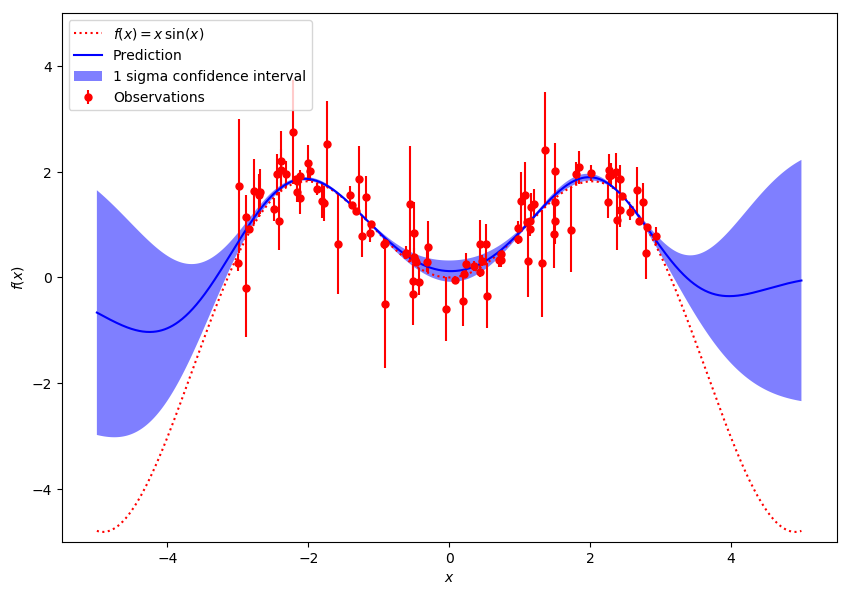

In [7]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x_gp = np.atleast_2d(np.linspace(-5, 5, 1000)).T

# ----------------------------------------------------------------------
# now the noisy case
X = np.random.uniform(-3, 3, 100)
X = np.atleast_2d(X).T

# Observations and noise
y_gp = gen_function(X).ravel()
dy = np.random.normal(0.0, 0.5, size=y_gp.shape)
y_gp += dy

# Instanciate a Gaussian Process model
kernel = C(1, (1e-3, 1e3)) * RBF(10, (1e-3, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, alpha=(dy / y_gp) ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y_gp)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x_gp, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure(figsize=(10, 7), dpi=100)
plt.plot(x_gp, gen_function(x_gp), 'r:', label=u'$f(x) = x\,\sin(x)$')
plt.errorbar(X.ravel(), y_gp, dy, fmt='r.', markersize=10, label=u'Observations')
plt.plot(x_gp, y_pred, 'b-', label=u'Prediction')
plt.fill(np.concatenate([x_gp, x_gp[::-1]]),
         np.concatenate([y_pred - 1.96 * sigma,
                        (y_pred + 1.96 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='1 sigma confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-5, 5)
plt.legend(loc='upper left')

plt.show()

# Third, use a single model to get both epistemic and aleatoric uncertainty with variational inference

#### Please notice you need to apply Dense layer with varational method from Tensorflow Probability.

For more information on the astroNN loss functions (mse_lin_wrapper, mse_var_wrapper) used in here: http://astronn.readthedocs.io/en/latest/neuralnets/losses_metrics.html#regression-loss-and-predictive-variance-loss-for-bayesian-neural-net

Please refer to the Paper: [Flipout: Efficient Pseudo-Independent Weight Perturbations on Mini-Batches](https://arxiv.org/abs/1803.04386)
 for the information of DenseFlipout.
 
Frist we will define a "fork" model using Keras functional API, one end ouput the prediction, and the other end ouput predicted uncertainty

In [8]:
from astroNN.nn.losses import mse_lin_wrapper, mse_var_wrapper
# http://astronn.readthedocs.io/en/latest/neuralnets/losses_metrics.html

import tensorflow_probability as tfp
import tensorflow as tf

def generate_train_batch(x, y, x_mean, x_std, y_mean, y_std, y_err):
    while True:
        indices = random.sample(range(0, x.shape[0]), batch_size)
        indices = np.sort(indices)
        x_batch, y_batch, y_err_batch = normalize(x[indices], x_mean, x_std), normalize(y[indices], y_mean, y_std), normalize(y_err[indices], 0., y_std)
        yield ({'input': x_batch, 'label_err': y_err_batch}, {'linear_output': y_batch, 'variance_output': y_batch})

def model_regression_var(num_hidden):
    # Define Keras Model
    input_tensor = tf.keras.layers.Input(batch_shape=(None, 1), name='input')
    labels_err_tensor = tf.keras.layers.Input(batch_shape=(None, 1), name='label_err')
    layer_1 = tfp.layers.DenseFlipout(units=num_hidden[0], activation='relu')(input_tensor)
    layer_2 = tfp.layers.DenseFlipout(units=num_hidden[1], activation='relu')(layer_1)
    layer_3 = tfp.layers.DenseFlipout(units=num_hidden[2], activation='relu')(layer_2)

    # Good old output
    linear_output = tf.keras.layers.Dense(units=1, activation="linear", name='linear_output')(layer_3)

    # Data-dependent uncertainty outainty
    variance_output = tf.keras.layers.Dense(units=1, activation='linear', name='variance_output')(layer_3)
    
    model = tf.keras.Model(inputs=[input_tensor, labels_err_tensor], outputs=[variance_output, linear_output])
    model_prediction = tf.keras.Model(inputs=input_tensor, outputs=[variance_output, linear_output])
    
    mse_var_ext = mse_var_wrapper(linear_output, labels_err_tensor)
    mse_lin_ext = mse_lin_wrapper(variance_output, labels_err_tensor)

    return model, model_prediction, mse_lin_ext, mse_var_ext

![title](model.png)

Then we will define two custom loss and custom data generator

<br>
The custom loss function for variance prediction will be<br>
$\text{Loss}=\frac{1}{T} \sum_1^T \frac{1}{2} \frac{(y-\hat{y})^{2}}{\sigma^{2}} + \frac{1}{2}\text{log}(\sigma^{2})$
<br>
<br>
But for the sake of numerical stability, its better to make the neural net to predict $\text{s} = \text{log}(\sigma^{2})$ with <br>
$\text{Loss}=\frac{1}{T} \sum_1^T \frac{1}{2} (y-\hat{y})^{2}e^{-\text{s}} + \frac{1}{2}(\text{s})$

Please ensure if you are using these loss functions, please make sure sigma from your data is gaussian distributed.
<br>
<br>
Please notice if you use the first loss, you have to use $softplus$ as activation in the last layer as $\sigma^{2}$ is always positve, and $linear$ or other appropriate activation for second loss as $\text{log}(\sigma^{2})$ can be both positive and negative.
<br>

$\text{Prediction} = \text{Mean from Variational Dense Layers}$
<br>
$\text{Total Variance} = \text{Variance from Variational Dense Layers} + \text{Predictive Variance Output}$

<br>
$\text{Prediction with Error} = \text{Prediction} \pm \sqrt{\text{Total Variance}}$

C:\Users\Henry\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
C:\Users\Henry\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
C:\Users\Henry\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
C:\Users\Henry\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
C:\Users\Henry\Anaconda3\lib\site-packages\tensorflow\python\util\tf_inspect.py:75: 

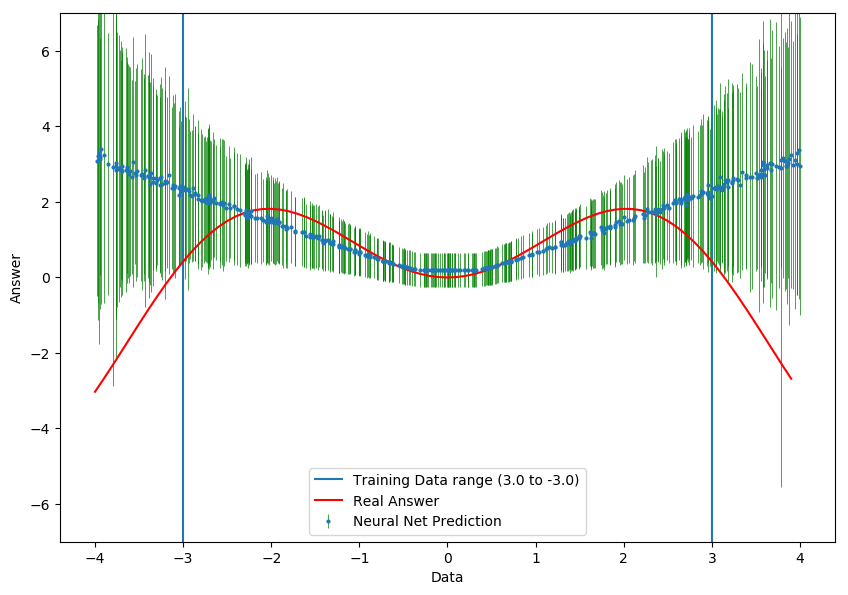

In [14]:
#Define some parameter
batch_size = 32
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)

# Compile Keras model
num_hidden = [100, 75, 50]
model, model_prediction, mse_lin_ext, mse_var_ext = model_regression_var(num_hidden)
model.compile(loss={'linear_output': mse_lin_ext, 'variance_output': mse_var_ext}, 
              loss_weights={'linear_output': .5, 'variance_output': .5}, optimizer=optimizer)
model.fit_generator(generator=generate_train_batch(x, y, x_mean, x_std, y_mean, y_std, y_err), epochs=100, 
                    max_queue_size=60, verbose=0, steps_per_epoch= x.shape[0] // batch_size)

# Generate test data
test_batch_size = 500
x_test = np.random.uniform(-4, 4, test_batch_size)

mc_num = 100

predictions = np.zeros((mc_num, test_batch_size, 1))
predictions_var = np.zeros((mc_num, test_batch_size, 1))
var = np.zeros((mc_num, test_batch_size, 1))
uncertainty = np.zeros((mc_num, test_batch_size, 1))

for i in range(mc_num):    
    result = np.array(model_prediction.predict(normalize(x_test.reshape((x_test.shape[0], 1)), x_mean, x_std)))
    predictions[i] = result[1].reshape((test_batch_size,1))
    predictions_var[i] = result[0].reshape((test_batch_size,1))
    
predictions = denormalize(predictions, y_mean, y_std)
predictions_var = denormalize(predictions_var, np.zeros(predictions_var.shape), y_std)

# get mean results and its varience and mean unceratinty
prediction_mc_droout = np.mean(predictions, axis=0)
var = np.mean(np.exp(predictions_var), axis=0)
var_mc_droout = np.var(predictions, axis=0)

total_variance = var + var_mc_droout  # epistemic plus aleatoric uncertainty
total_uncertainty = np.sqrt(total_variance)
    
# Array for the real equation
x_true = np.arange(-4,4,0.1)
y_true = gen_function(x_true)

# Plotting
plt.figure(figsize=(10, 7), dpi=100)
plt.errorbar(x_test, prediction_mc_droout, yerr=total_uncertainty, markersize=2,fmt='o', ecolor='g', capthick=2, 
             elinewidth=0.5, label='Neural Net Prediction')
plt.axvline(x=-3.0, label="Training Data range (3.0 to -3.0)")
plt.axvline(x=3.0)
plt.plot(x_true, y_true, color='red', label='Real Answer')
plt.ylim(-7,7)
plt.xlabel('Data')
plt.ylabel('Answer')
plt.legend(loc='best')
plt.show()